## XGBoost ML-Model. 

###### A. part of Notebook is regional learning with the IT_AT/WGMS dataset. B. part is transfer learning with Swiss/GLAMOS train set and IT_AT/WGMS test set

### Setting Up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import numpy as np

from scripts.helpers import *
from scripts.italy_austria_preprocess import *
from scripts.plots import *
from scripts.config_IT_AT import *
from scripts.xgb_helpers import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.ItalyAustriaConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/IT_AT/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'
color_orange = '#FFA500'



vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
]

#### A.1. Read in stake data from preprocess, transform to monthly and add ERA5Land data

###### Load csv into df

In [3]:
data_wgms = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'IT_AT_wgms_dataset_all_oggm.csv')

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns

Number of glaciers: 24
Number of winter, summer and annual samples: 5086
Number of annual samples: 2872
Number of winter samples: 1548
Number of summer samples: 666


Index(['POINT_ID', 'POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE',
       'TO_DATE', 'POINT_BALANCE', 'GLACIER', 'PERIOD', 'RGIId', 'YEAR',
       'DATA_MODIFICATION', 'aspect', 'slope', 'topo', 'hugonnet_dhdt',
       'consensus_ice_thickness'],
      dtype='object')

###### Transform into monthly and add ERA5Land

In [4]:
data_wgms_test = data_wgms.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': '/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/ERA5Land/raw/era5_monthly_averaged_data_Alps.nc', #cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_Alps.nc'
    'geopotential_data': '/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/ERA5Land/raw/era5_geopotential_pressure_Alps.nc'  #cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_Alps.nc'
}

RUN = True
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_wgms_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'IT_AT_wgms_dataset_monthly_full.csv')
data_monthly = dataloader_gl.data

display(data_monthly.head(2))

2025-06-17 12:56:10,984 - INFO - Number of annual and seasonal samples: 5086
2025-06-17 12:56:10,986 - INFO - Running on 24 glaciers:
['GOLDBERG K.' 'HINTEREIS F.' 'JAMTAL F.' 'KESSELWAND F.' 'KLEINFLEISS K.'
 'OE. WURTEN K.' 'VERNAGT F.' 'CARESER'
 'MALAVALLE (VEDR. DI) / UEBELTALF.' 'PENDENTE (VEDR.) / HANGENDERF.'
 'RIES OCC. (VEDR. DI) / RIESERF. WESTL.' 'GRAND ETRET' 'HALLSTAETTER G.'
 'VENEDIGER K.' 'ZETTALUNITZ/MULLWITZ K.' 'CIARDONEY'
 'FONTANA BIANCA / WEISSBRUNNF.' 'LUNGA (VEDRETTA) / LANGENF.'
 'CAMPO SETT.' 'LUPO' 'SURETTA MERIDIONALE' 'CARESER OCCIDENTALE'
 'CARESER ORIENTALE' 'CARESER CENTRALE']
2025-06-17 12:56:10,998 - INFO - Number of annual samples: 2872
2025-06-17 12:56:11,000 - INFO - Number of winter samples: 1548
2025-06-17 12:56:11,001 - INFO - Number of summer samples: 666
2025-06-17 12:56:11,002 - INFO - Adding climate features...
2025-06-17 12:56:14,155 - INFO - Converting to monthly resolution...
2025-06-17 12:56:26,906 - INFO - Number of monthly rows: 50833


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2020  12.965073  47.041127          0.276       2005.391746   
1  2020  12.965073  47.041127          0.276       2005.391746   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            694.608254           2700.0  RGI60-11.00289   
1            694.608254           2700.0  RGI60-11.00289   

                    POINT_ID  ID  ...  consensus_ice_thickness       t2m  \
0  GOLDBERG K._2020_43346_AT   0  ...                48.199932  4.489166   
1  GOLDBERG K._2020_43346_AT   0  ...                48.199932 -2.252045   

         tp       slhf       sshf       ssrd       fal        str       u10  \
0  0.003263 -2294156.0 -1238456.0  9166658.0  0.229964 -3531426.0  0.265247   
1  0.011189  -350702.0  -297682.0  5373324.0  0.610374 -2029100.0  0.098144   

        v10  
0  0.430276  
1  0.601274  

[2 rows x 27 columns]

#### A.2. Dataset statistics

In [ ]:
plotHeatmap(data_monthly, period='annual', plot_elevation=True)

In [ ]:
data_monthly.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_orange, color_pink])
plt.title('Number of measurements per year for all glaciers')

In [ ]:
# Plot feature intercorrelation
plot_feature_correlation(dataloader_gl.data)

In [ ]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate
df = df[(df.GLACIER == 'OE. WURTEN K.') & (df.YEAR == 2015)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

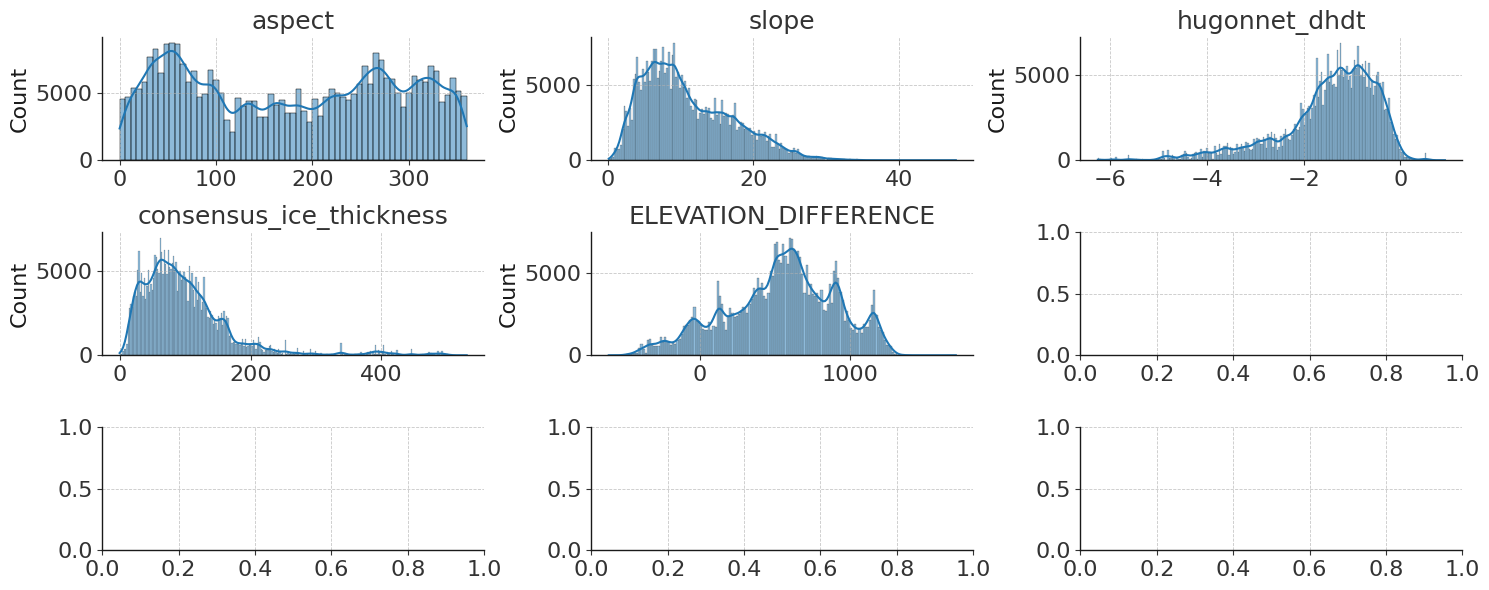

In [24]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

### A.3. Train-test set split:

###### Either run A.3.1. or A.3.2.

##### A.3.1. Spatial Cross-Validation

###### Uses specific glaciers as test set

In [5]:
test_glaciers = [
    'GOLDBERG K.', 'HALLSTAETTER G.', 'HINTEREIS F.', 'JAMTAL F.',
    'KESSELWAND F.', 'KLEINFLEISS K.', 'OE. WURTEN K.', 'VENEDIGER K.',
    'VERNAGT F.', 'ZETTALUNITZ/MULLWITZ K.'
]

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))




Size of test data: 21454
Size of train data: 29379
Percentage of test size: 73.02%
Train glaciers: (14) ['CARESER' 'MALAVALLE (VEDR. DI) / UEBELTALF.'
 'PENDENTE (VEDR.) / HANGENDERF.' 'RIES OCC. (VEDR. DI) / RIESERF. WESTL.'
 'GRAND ETRET' 'CIARDONEY' 'FONTANA BIANCA / WEISSBRUNNF.'
 'LUNGA (VEDRETTA) / LANGENF.' 'CAMPO SETT.' 'LUPO' 'SURETTA MERIDIONALE'
 'CARESER OCCIDENTALE' 'CARESER ORIENTALE' 'CARESER CENTRALE']
Test glaciers: (10) ['GOLDBERG K.' 'HINTEREIS F.' 'JAMTAL F.' 'KESSELWAND F.' 'KLEINFLEISS K.'
 'OE. WURTEN K.' 'VERNAGT F.' 'HALLSTAETTER G.' 'VENEDIGER K.'
 'ZETTALUNITZ/MULLWITZ K.']


##### A.3.2. Temporal Cross-Validation

###### Uses the last X years as test set

In [ ]:
test_years_count = 10

all_years = sorted(dataloader_gl.data['YEAR'].unique())

# Use the most recent years as test data
train_years = all_years[:-test_years_count]
test_years = all_years[-test_years_count:]

# Statistics prints
print('Size of test data:', len(test_years))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_years)]
print('Size of train data:', len(train_years))
if len(train_years) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(test_years) / len(train_years)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(
                                dataloader_gl,
                                test_split_on='YEAR',
                                test_splits=test_years,
                                random_state=cfg.seed)



print('Train year: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test years: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))


##### A.3.3. Train-Test set plots

In [ ]:
plotHeatmap(dataloader_gl.data, test_glaciers, period='annual')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='winter')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='summer')
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink, color_orange], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink, color_orange], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

plot_climate_glacier_elevations(test_glaciers, test_set)

In [ ]:
# plot distributions of test glaciers:
f, ax = plt.subplots(len(test_glaciers),
                     len(vois_climate) + 3,
                     figsize=(16, 10),
                     sharey='row',
                     sharex='col')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl['POINT_BALANCE'].plot.hist(ax=ax[i, 0],
                                          color=color_dark_blue,
                                          alpha=0.6,
                                          density=False)
    ax[i, 0].set_title('PMB')
    ax[i, 0].set_ylabel(test_gl)
    ax[i, 0].set_xlabel('[m w.e.]')
    test_df_gl['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[i, 1],
                                                 color=color_dark_blue,
                                                 alpha=0.6,
                                                 density=False)
    ax[i, 1].set_title('ELV_DIFF]')
    ax[i, 1].set_xlabel('[m]')

    for j, voi_clim in enumerate(vois_climate):
        ax[i, 2 + j].set_title(voi_clim)
        test_df_gl[voi_clim].plot.hist(ax=ax[i, 2 + j],
                                       color=color_dark_blue,
                                       alpha=0.6,
                                       density=False)
        ax[i, 2 + j].set_xlabel(vois_units[voi_clim])

plt.tight_layout()

#### A.4. XGBoost:

In [6]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = 1

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
]

###### Grid search:

In [7]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'IT_train_AT_test_reworked_11_06.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'IT_train_AT_test_reworked_11_06.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (29379, 25)
Shape of testing dataset: (21454, 25)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness']
Best parameters:
 {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1}
Best score:
 -0.14301958937133807
Shape of the test: (21454, 14)
Overall score: 2.4417768930297137
CPU times: user 340 ms, sys: 169 ms, total: 509 ms
Wall time: 280 ms


learning_rate  max_depth  n_estimators  Validation rmse  Train rmse
Model                                                                     
1               0.10          6           500         0.143020    0.001352
2               0.10          6           400         0.144218    0.001947
3               0.01          8           500         0.148207    0.010019
4               0.10          6           200         0.151707    0.006795
5               0.10          4           500         0.152456    0.014496
6               0.10          5           700         0.152720    0.002341
7               0.10          7           700         0.153197    0.000649
8               0.10          7           400         0.153553    0.000871
9               0.10          5           400         0.158457    0.006144
10              0.10          8           700         0.168673    0.000633

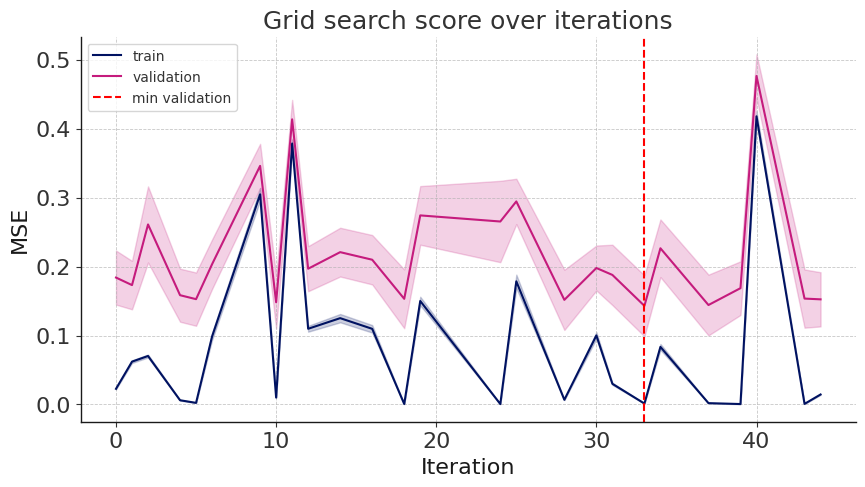

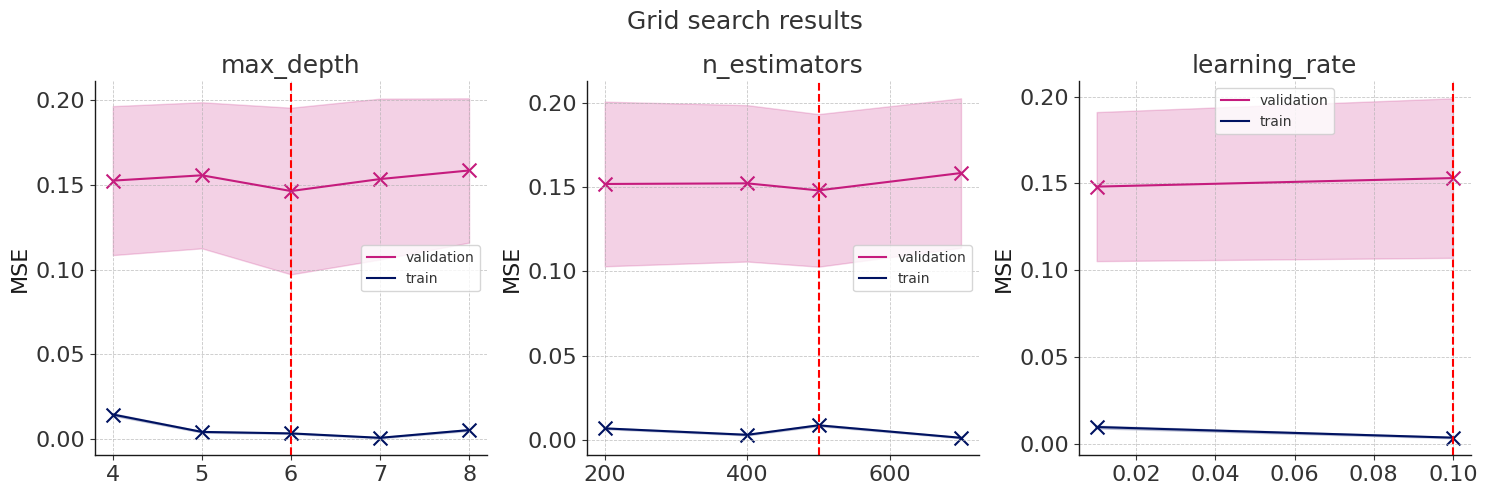

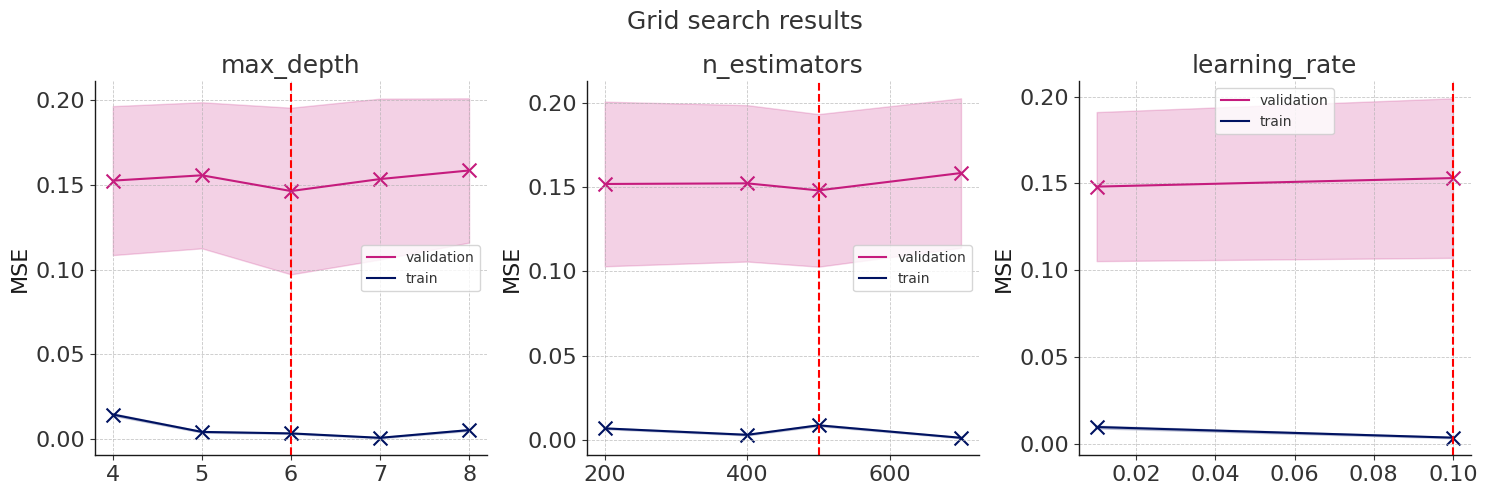

In [8]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

print_top_n_models(custom_xgboost.param_search.cv_results_)

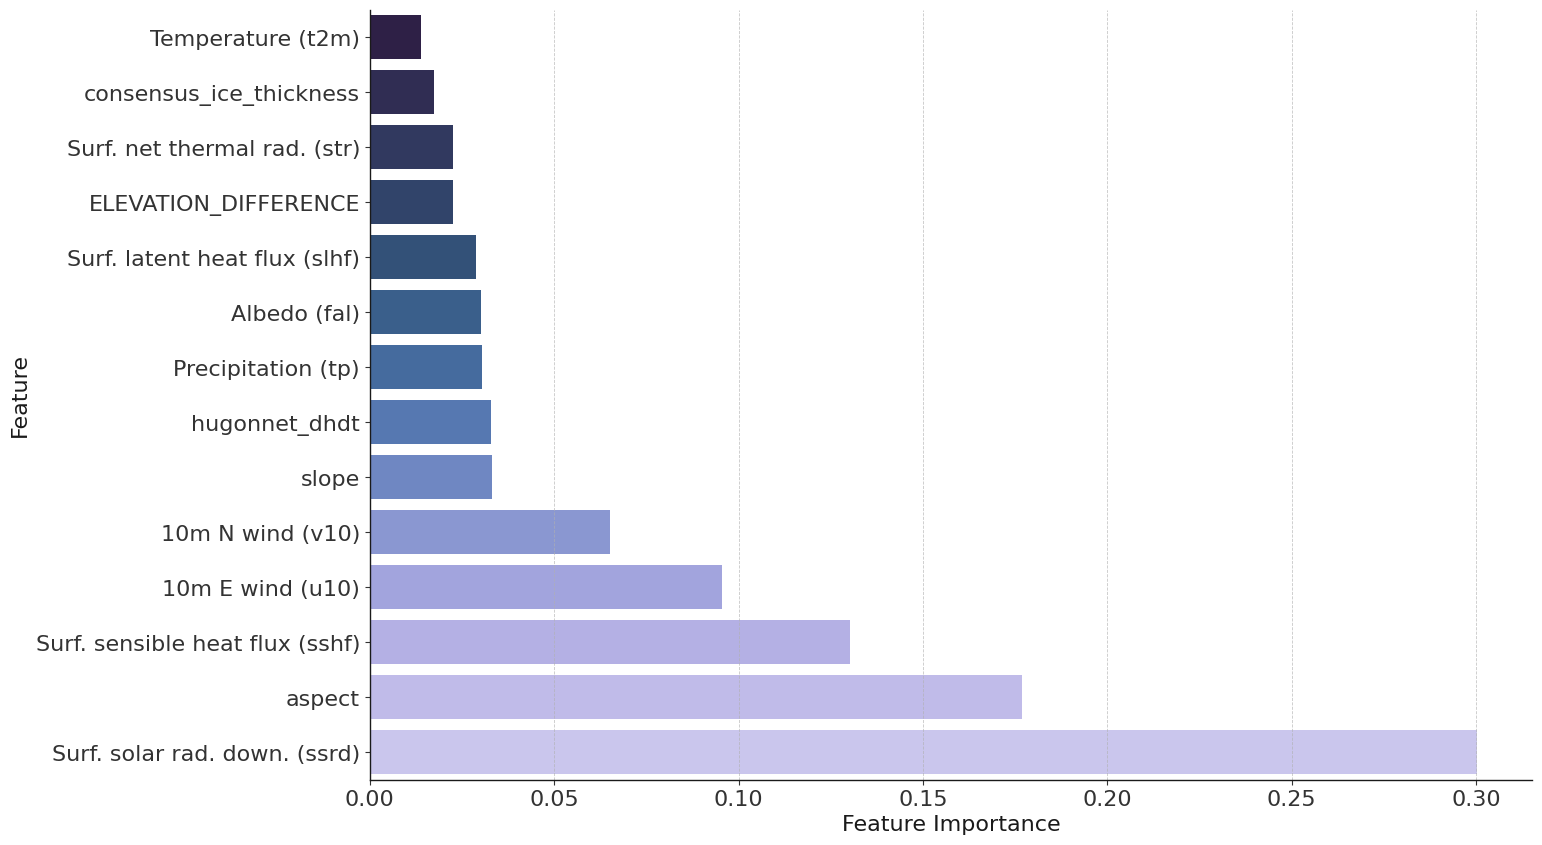

In [9]:
FIPlot(best_estimator, feature_columns, vois_climate)

###### Predictions of best parameters:

Shape of the test: (21454, 14)


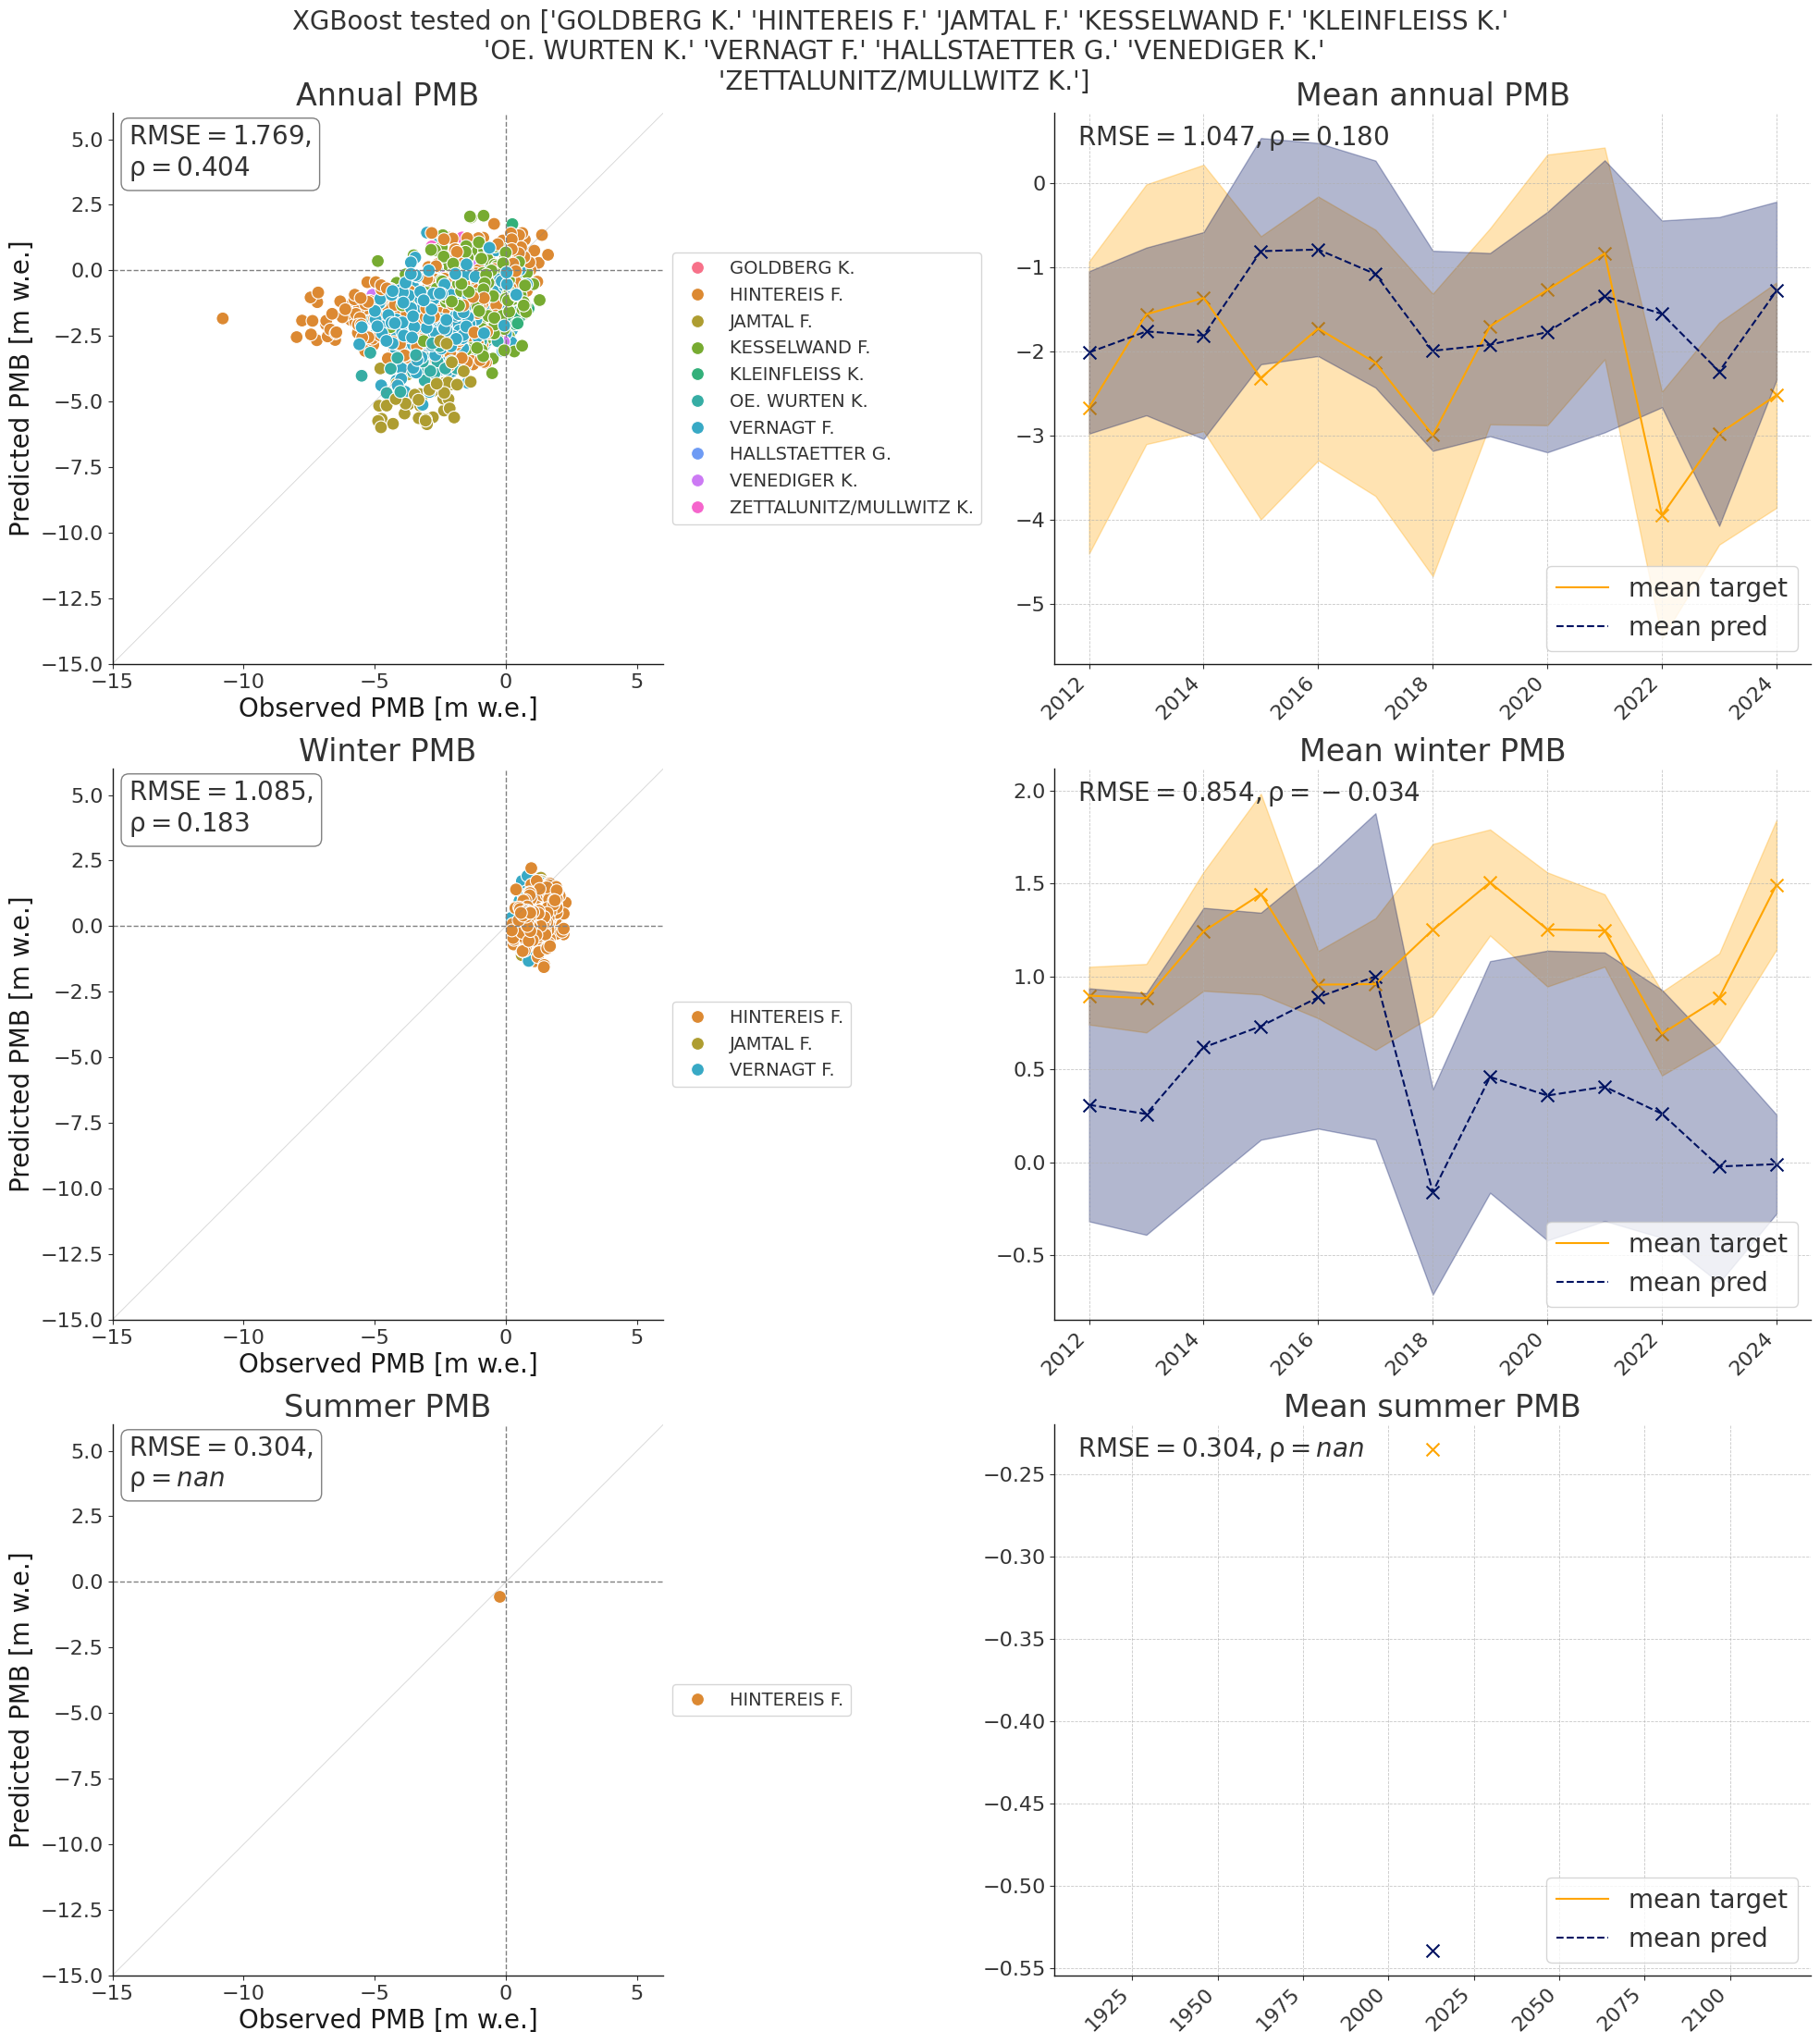

In [10]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, include_summer=True)
plt.suptitle(f'XGBoost tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

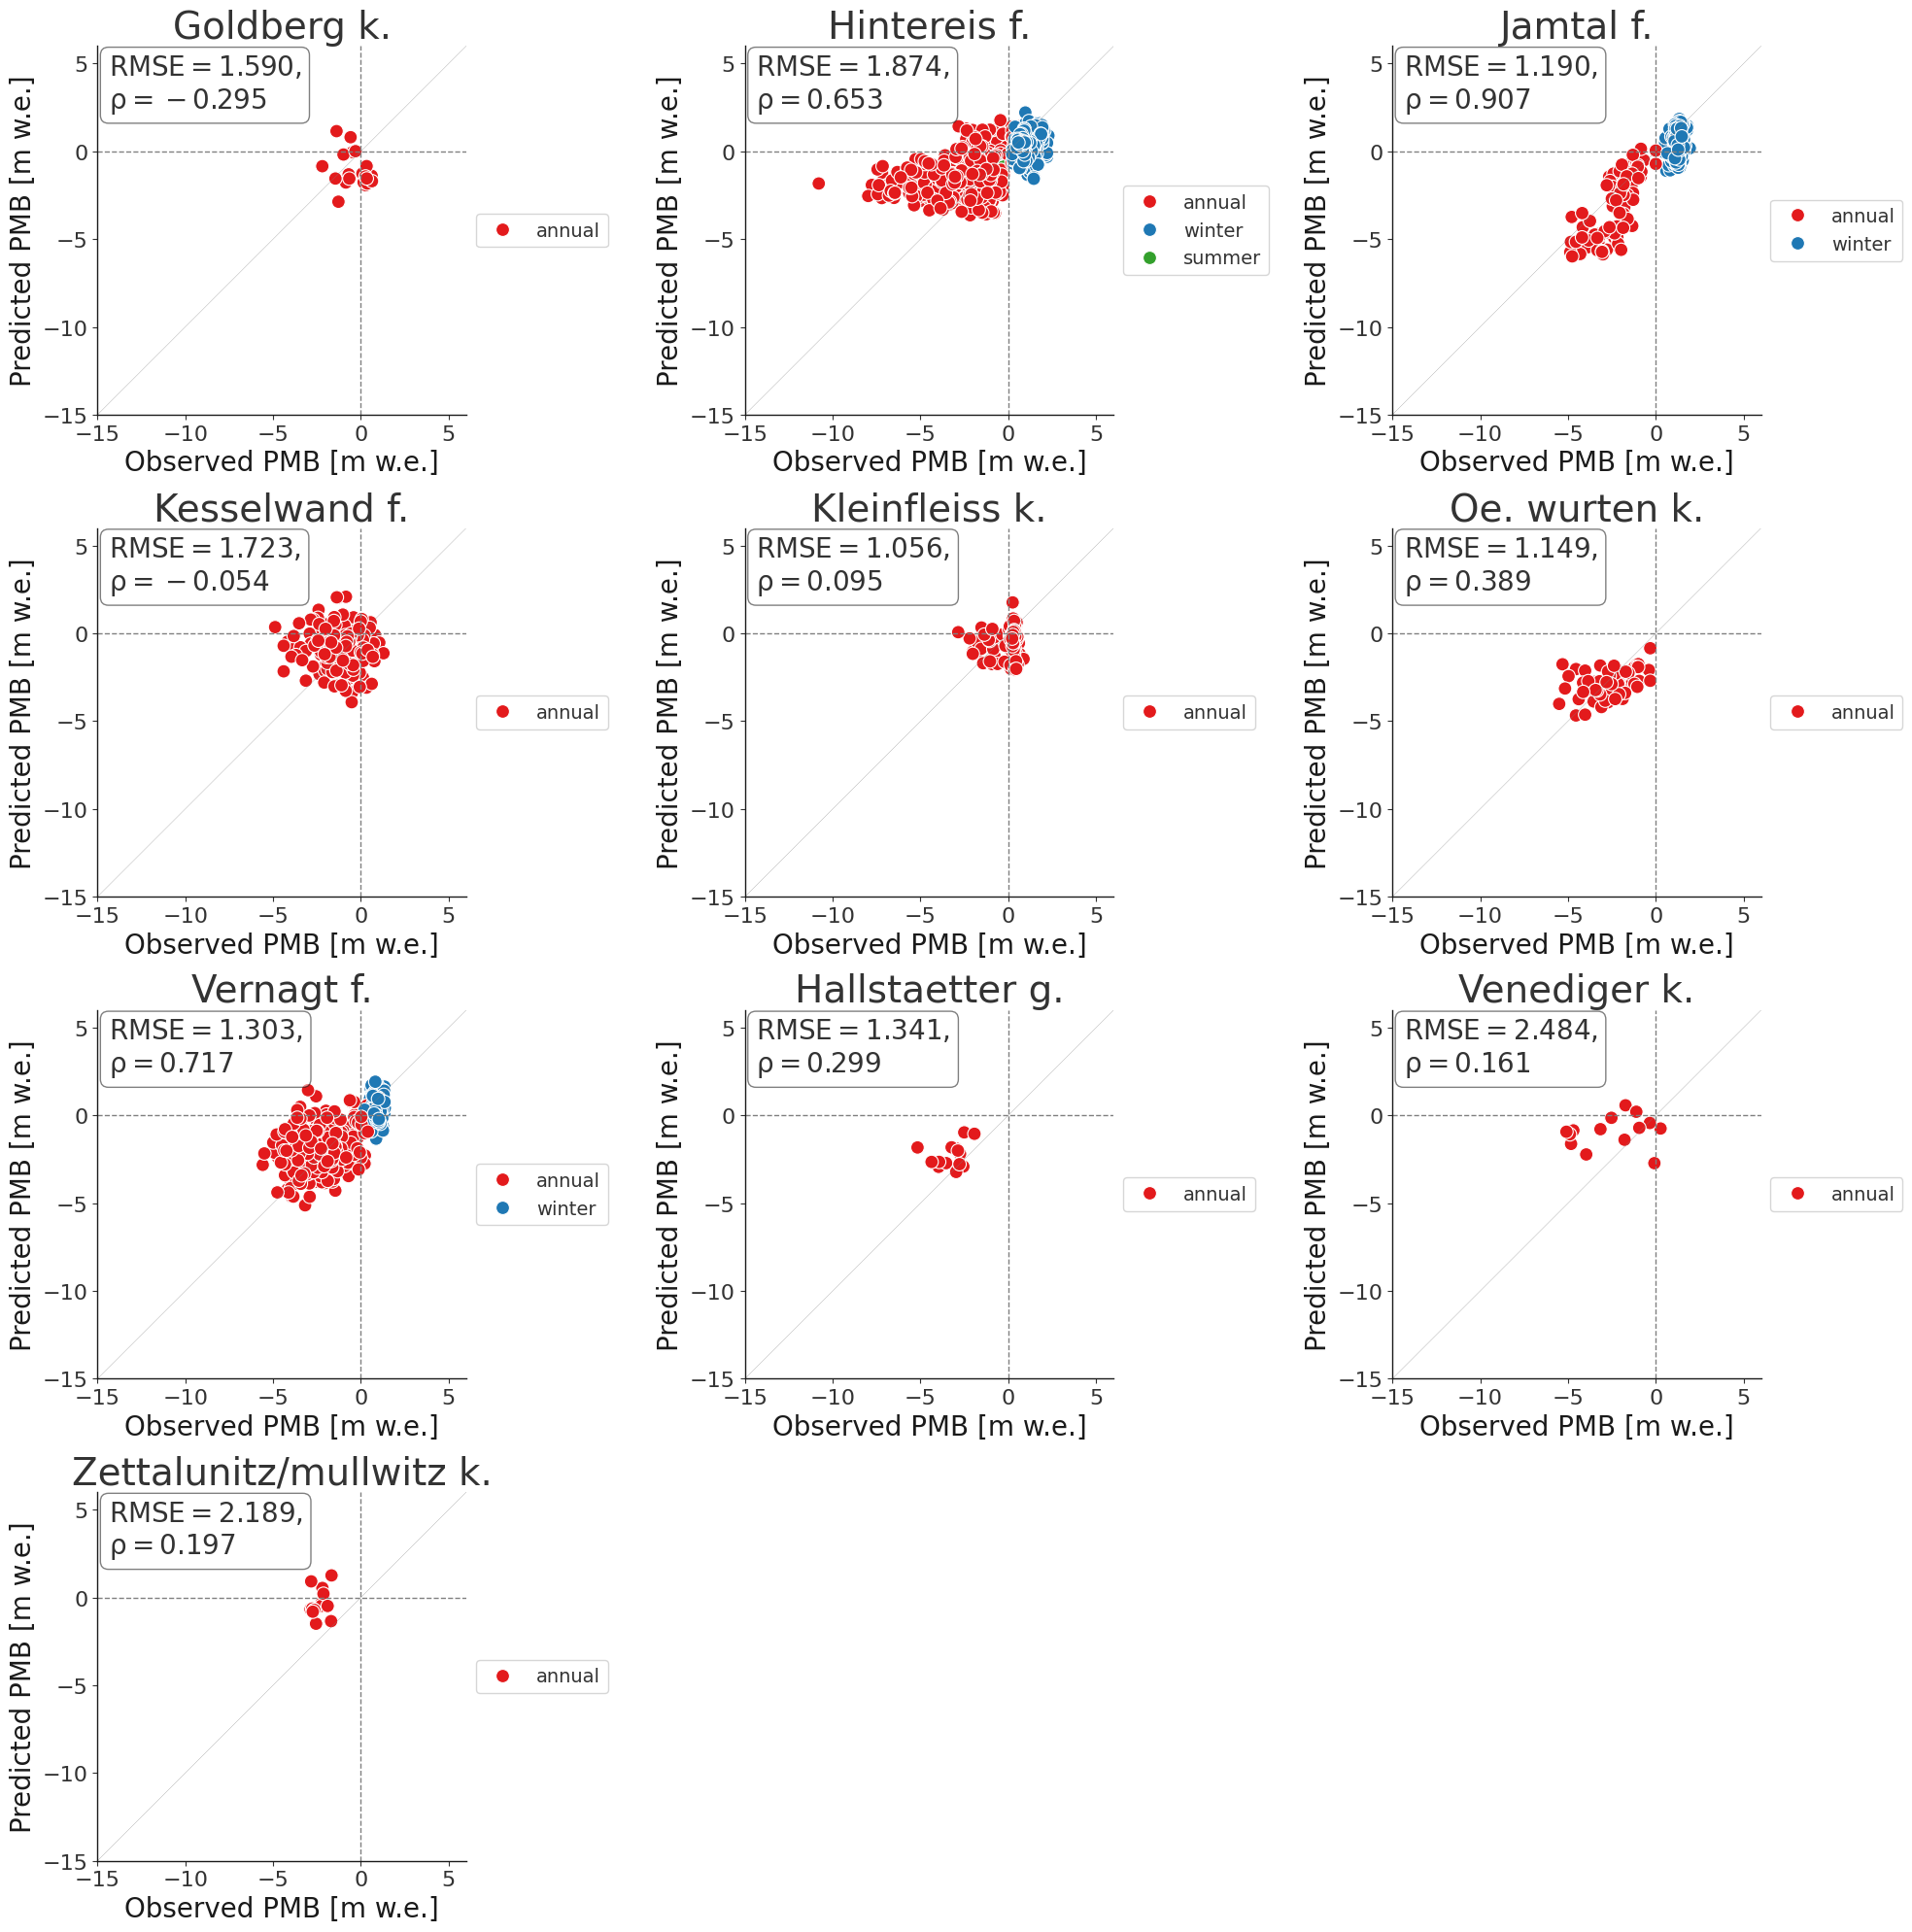

In [11]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

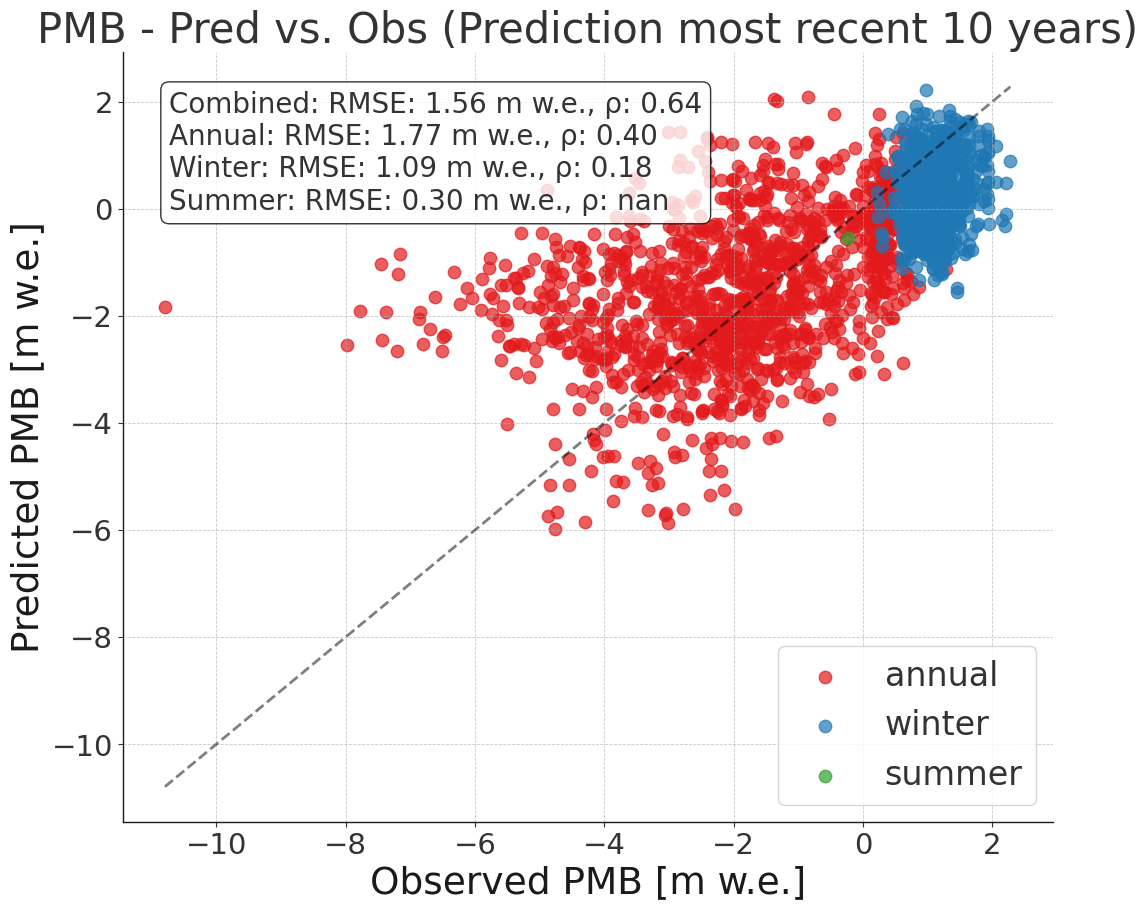

In [12]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='Prediction most recent 10 years', include_summer = True)

In [ ]:
# Search for points with large prediction errors
grouped_ids_test = grouped_ids.copy()
grouped_ids_test['pmb_diff'] = grouped_ids_test['target'] - grouped_ids_test['pred']
pd.set_option('display.max_colwidth', None) 
display(grouped_ids_test[abs(grouped_ids_test['pmb_diff'] > 1)
])
pd.reset_option('display.max_colwidth')

# Plot climate variables for specific points
point_ids = [ 'GOLDBERG K._2020_43366_AT'
]
plot_point_climate_variables(
    point_ids=point_ids,
    data_monthly=data_monthly,
    vois_climate=vois_climate,
    vois_units=vois_units
)

### B.1. Train CH Test FR

###### Load CH galciers and merge with IT_AT

In [13]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
data_IT_AT = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'IT_AT_wgms_dataset_all_oggm.csv')
data_IT_AT = data_IT_AT[data_IT_AT['PERIOD'] != 'summer']

display(data_CH.columns)

display(data_IT_AT.columns)

data_CH = data_CH.drop(['millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'], axis=1)

display(data_CH.columns)

# Merge CH with IT_AT
data_IT_AT_CH = pd.concat([data_IT_AT, data_CH], axis=0).reset_index(drop=True)

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'],
      dtype='object')

Index(['POINT_ID', 'POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE',
       'TO_DATE', 'POINT_BALANCE', 'GLACIER', 'PERIOD', 'RGIId', 'YEAR',
       'DATA_MODIFICATION', 'aspect', 'slope', 'topo', 'hugonnet_dhdt',
       'consensus_ice_thickness'],
      dtype='object')

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness'],
      dtype='object')

In [14]:
data_IT_AT_CH_test = data_IT_AT_CH.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': '/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/ERA5Land/raw/era5_monthly_averaged_data_Alps.nc', # cfg.dataPath + path_ERA5_raw 'era5_monthly_averaged_data_Alps.nc'
    'geopotential_data': '/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/ERA5Land/raw/era5_geopotential_pressure_Alps.nc'  # cfg.dataPath + path_ERA5_raw 'era5_geopotential_pressure_Alps.nc'
}

RUN = True
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_IT_AT_CH_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'CH_IT_AT_wgms_dataset_monthly_full.csv')
data_monthly_CH_IT_AT = dataloader_gl.data

display(data_monthly_CH_IT_AT.head(2))

2025-06-17 12:57:52,578 - INFO - Number of annual and seasonal samples: 37778
2025-06-17 12:57:52,582 - INFO - Running on 63 glaciers:
['GOLDBERG K.' 'HINTEREIS F.' 'JAMTAL F.' 'KESSELWAND F.' 'KLEINFLEISS K.'
 'OE. WURTEN K.' 'VERNAGT F.' 'CARESER'
 'MALAVALLE (VEDR. DI) / UEBELTALF.' 'PENDENTE (VEDR.) / HANGENDERF.'
 'RIES OCC. (VEDR. DI) / RIESERF. WESTL.' 'GRAND ETRET' 'HALLSTAETTER G.'
 'VENEDIGER K.' 'ZETTALUNITZ/MULLWITZ K.' 'CIARDONEY'
 'FONTANA BIANCA / WEISSBRUNNF.' 'LUNGA (VEDRETTA) / LANGENF.'
 'CAMPO SETT.' 'LUPO' 'SURETTA MERIDIONALE' 'CARESER OCCIDENTALE'
 'CARESER ORIENTALE' 'CARESER CENTRALE' 'adler' 'albigna' 'aletsch'
 'allalin' 'basodino' 'cantun' 'chessjen' 'clariden' 'corbassiere'
 'corvatsch' 'damma' 'findelen' 'forno' 'gietro' 'gorner' 'gries'
 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel' 'oberaar' 'otemma'
 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna' 'sardona'
 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta' 'taelliboden' 'tiefen'
 'tortin' '

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2020  12.965073  47.041127          0.276       2005.391746   
1  2020  12.965073  47.041127          0.276       2005.391746   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            694.608254           2700.0  RGI60-11.00289   
1            694.608254           2700.0  RGI60-11.00289   

                    POINT_ID  ID  ...  consensus_ice_thickness       t2m  \
0  GOLDBERG K._2020_43346_AT   0  ...                48.199932  4.489166   
1  GOLDBERG K._2020_43346_AT   0  ...                48.199932 -2.252045   

         tp       slhf       sshf       ssrd       fal        str       u10  \
0  0.003263 -2294156.0 -1238456.0  9166658.0  0.229964 -3531426.0  0.265247   
1  0.011189  -350702.0  -297682.0  5373324.0  0.610374 -2029100.0  0.098144   

        v10  
0  0.430276  
1  0.601274  

[2 rows x 27 columns]

In [15]:
test_glaciers = list(data_IT_AT['GLACIER'].unique())

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = list(data_CH['GLACIER'].unique())
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

Size of test data: 47883
Size of train data: 290682
Percentage of test size: 16.47%
Train glaciers: (39) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen'
 'clariden' 'corbassiere' 'corvatsch' 'damma' 'findelen' 'forno' 'gietro'
 'gorner' 'gries' 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel'
 'oberaar' 'otemma' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna'
 'sardona' 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta'
 'taelliboden' 'tiefen' 'tortin' 'tsanfleuron' 'vorab' 'witenwasseren']
Test glaciers: (24) ['GOLDBERG K.' 'HINTEREIS F.' 'JAMTAL F.' 'KESSELWAND F.' 'KLEINFLEISS K.'
 'OE. WURTEN K.' 'VERNAGT F.' 'CARESER'
 'MALAVALLE (VEDR. DI) / UEBELTALF.' 'PENDENTE (VEDR.) / HANGENDERF.'
 'RIES OCC. (VEDR. DI) / RIESERF. WESTL.' 'GRAND ETRET' 'HALLSTAETTER G.'
 'VENEDIGER K.' 'ZETTALUNITZ/MULLWITZ K.' 'CIARDONEY'
 'FONTANA BIANCA / WEISSBRUNNF.' 'LUNGA (VEDRETTA) / LANGENF.'
 'CAMPO SETT.' 'LUPO' 'SURETTA MERIDIONALE' 'CARESER OCCIDENTALE'
 'CARESER OR

In [ ]:
plotHeatmap(dataloader_gl.data, test_glaciers, period='annual')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='winter')
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

plot_climate_glacier_elevations(test_glaciers, test_set)

#### B.2.2. XGBoost Transfer Region

In [16]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = 1

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
]

#### Grid Search

In [17]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_CH_11_06_IT_AT.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_CH_11_06_IT_AT.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (290682, 25)
Shape of testing dataset: (47883, 25)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness']
Best parameters:
 {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01}
Best score:
 -0.1944065965918095
Shape of the test: (47883, 14)
Overall score: 1.1423767721348095
CPU times: user 371 ms, sys: 93 ms, total: 464 ms
Wall time: 246 ms


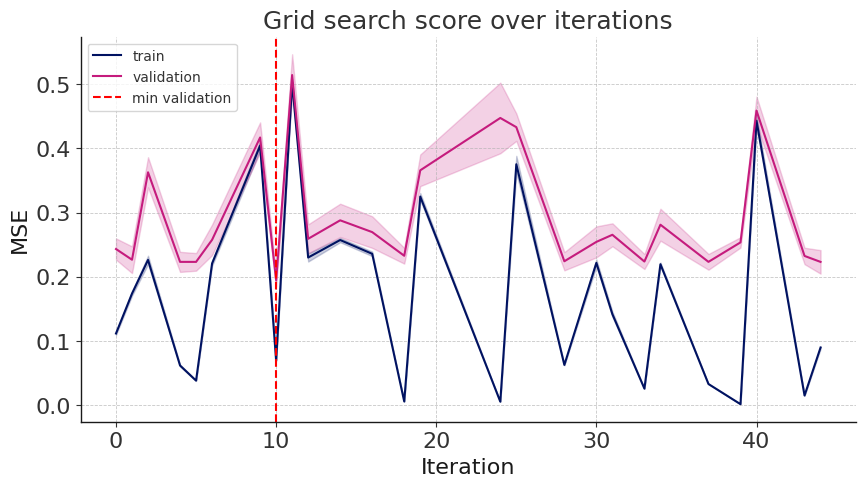

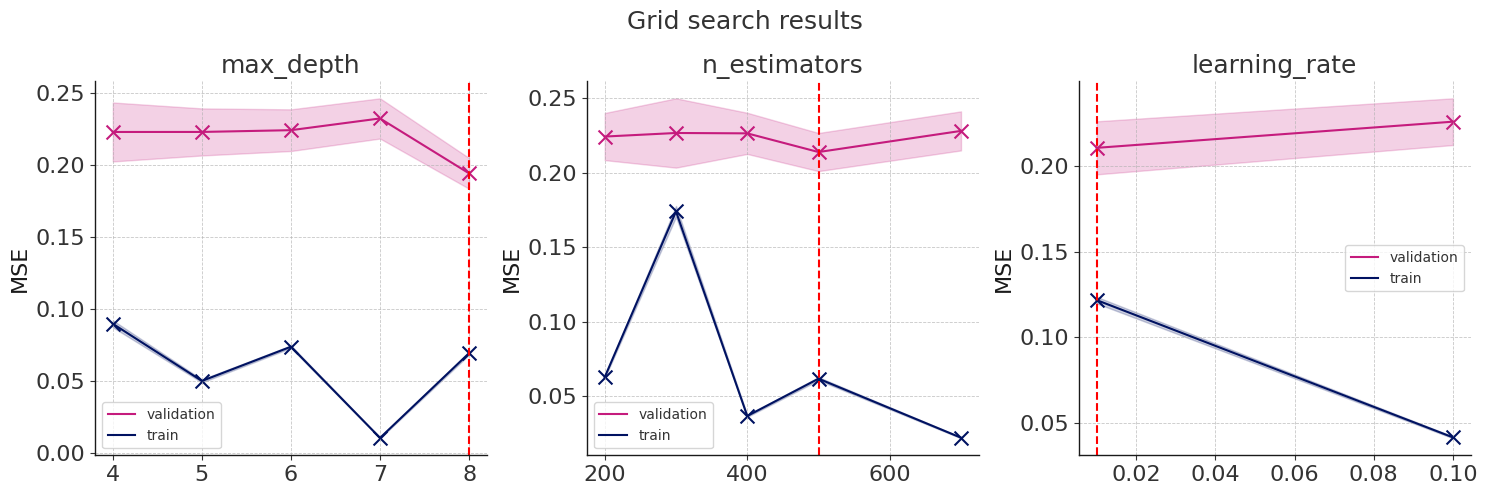

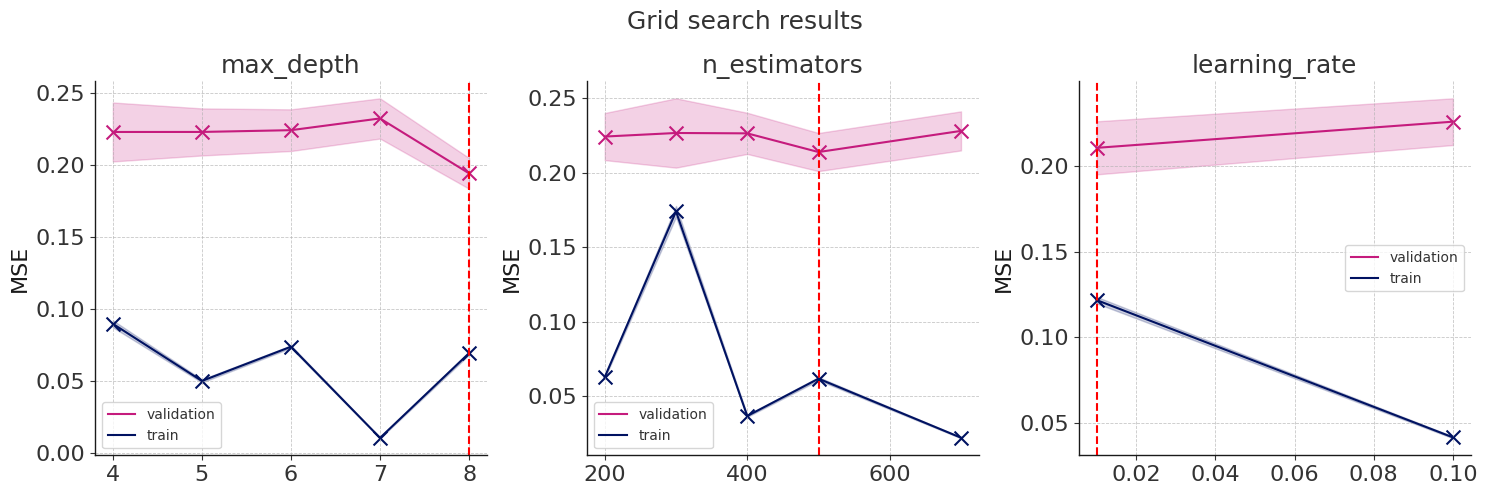

In [18]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

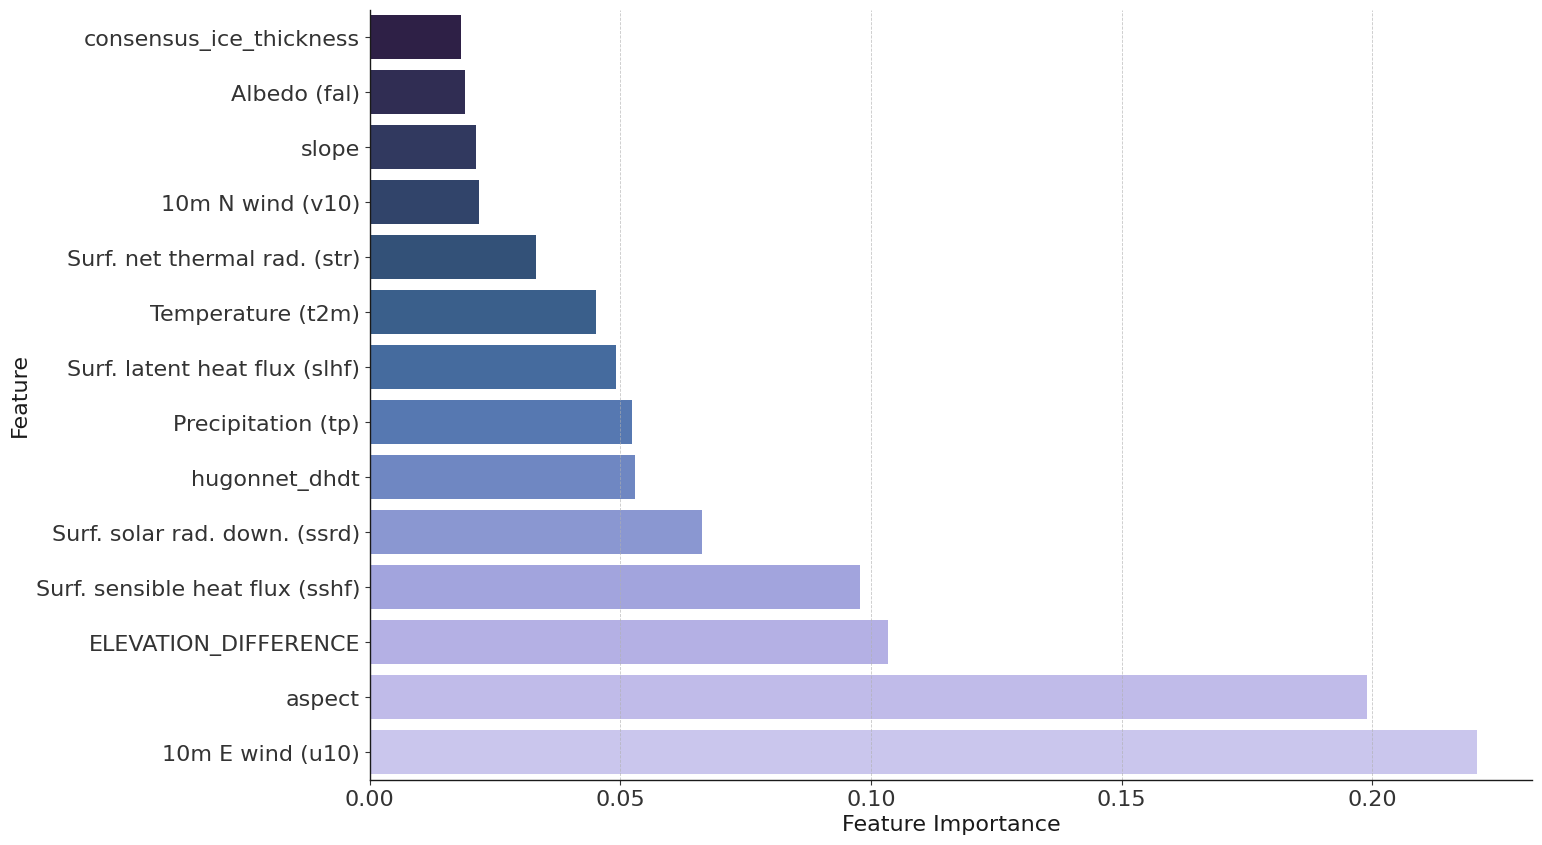

In [19]:
FIPlot(best_estimator, feature_columns, vois_climate)

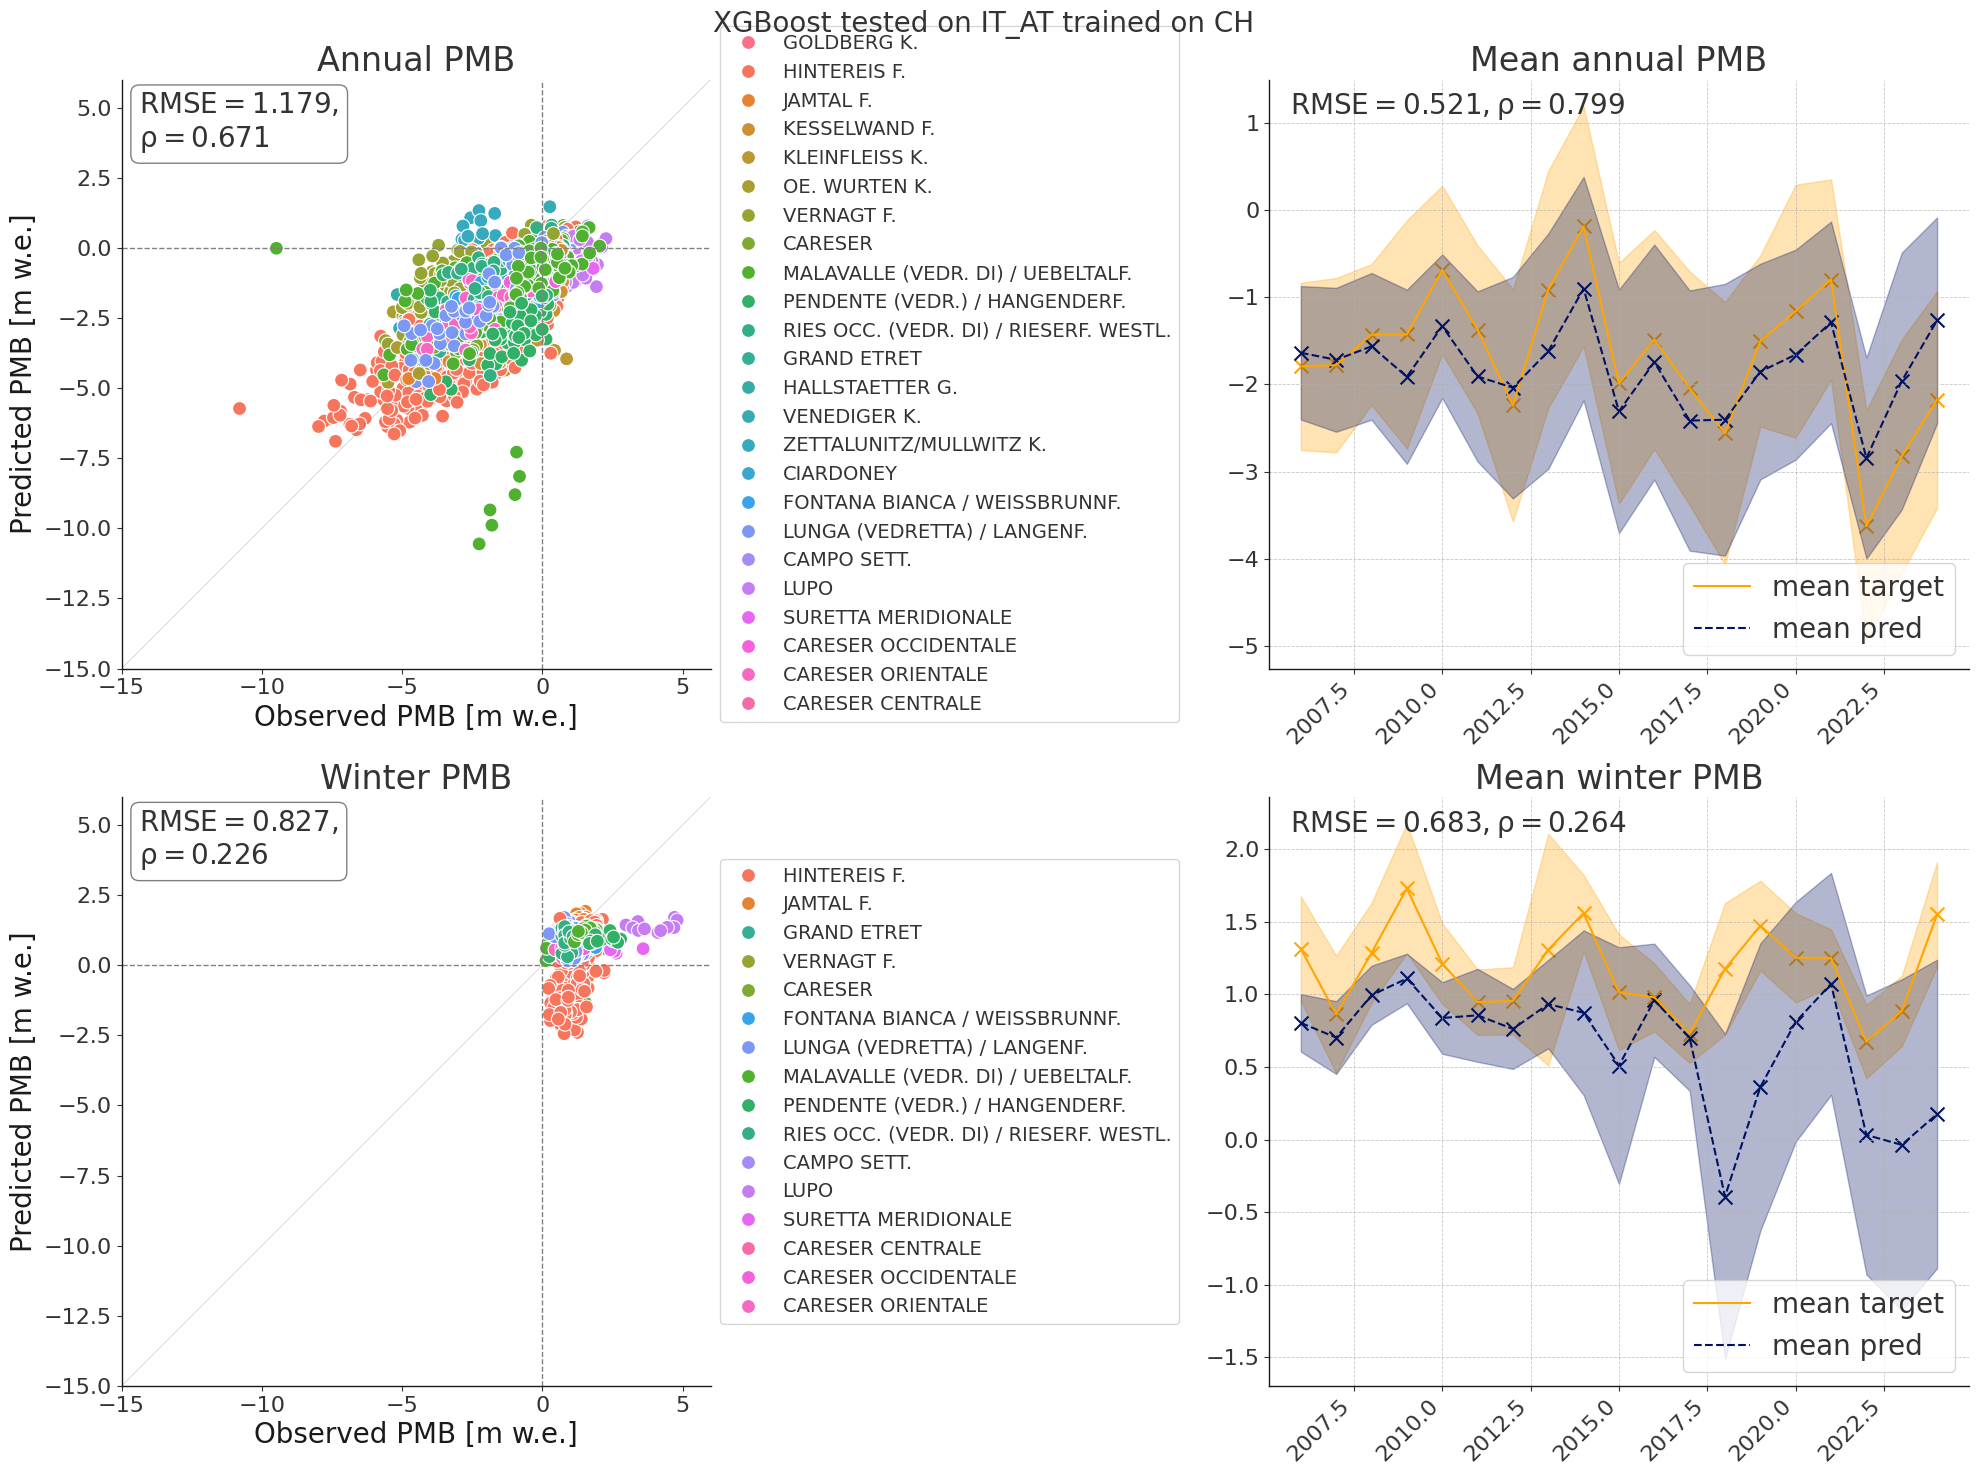

In [20]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)


PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on IT_AT trained on CH', fontsize=20)
plt.tight_layout()

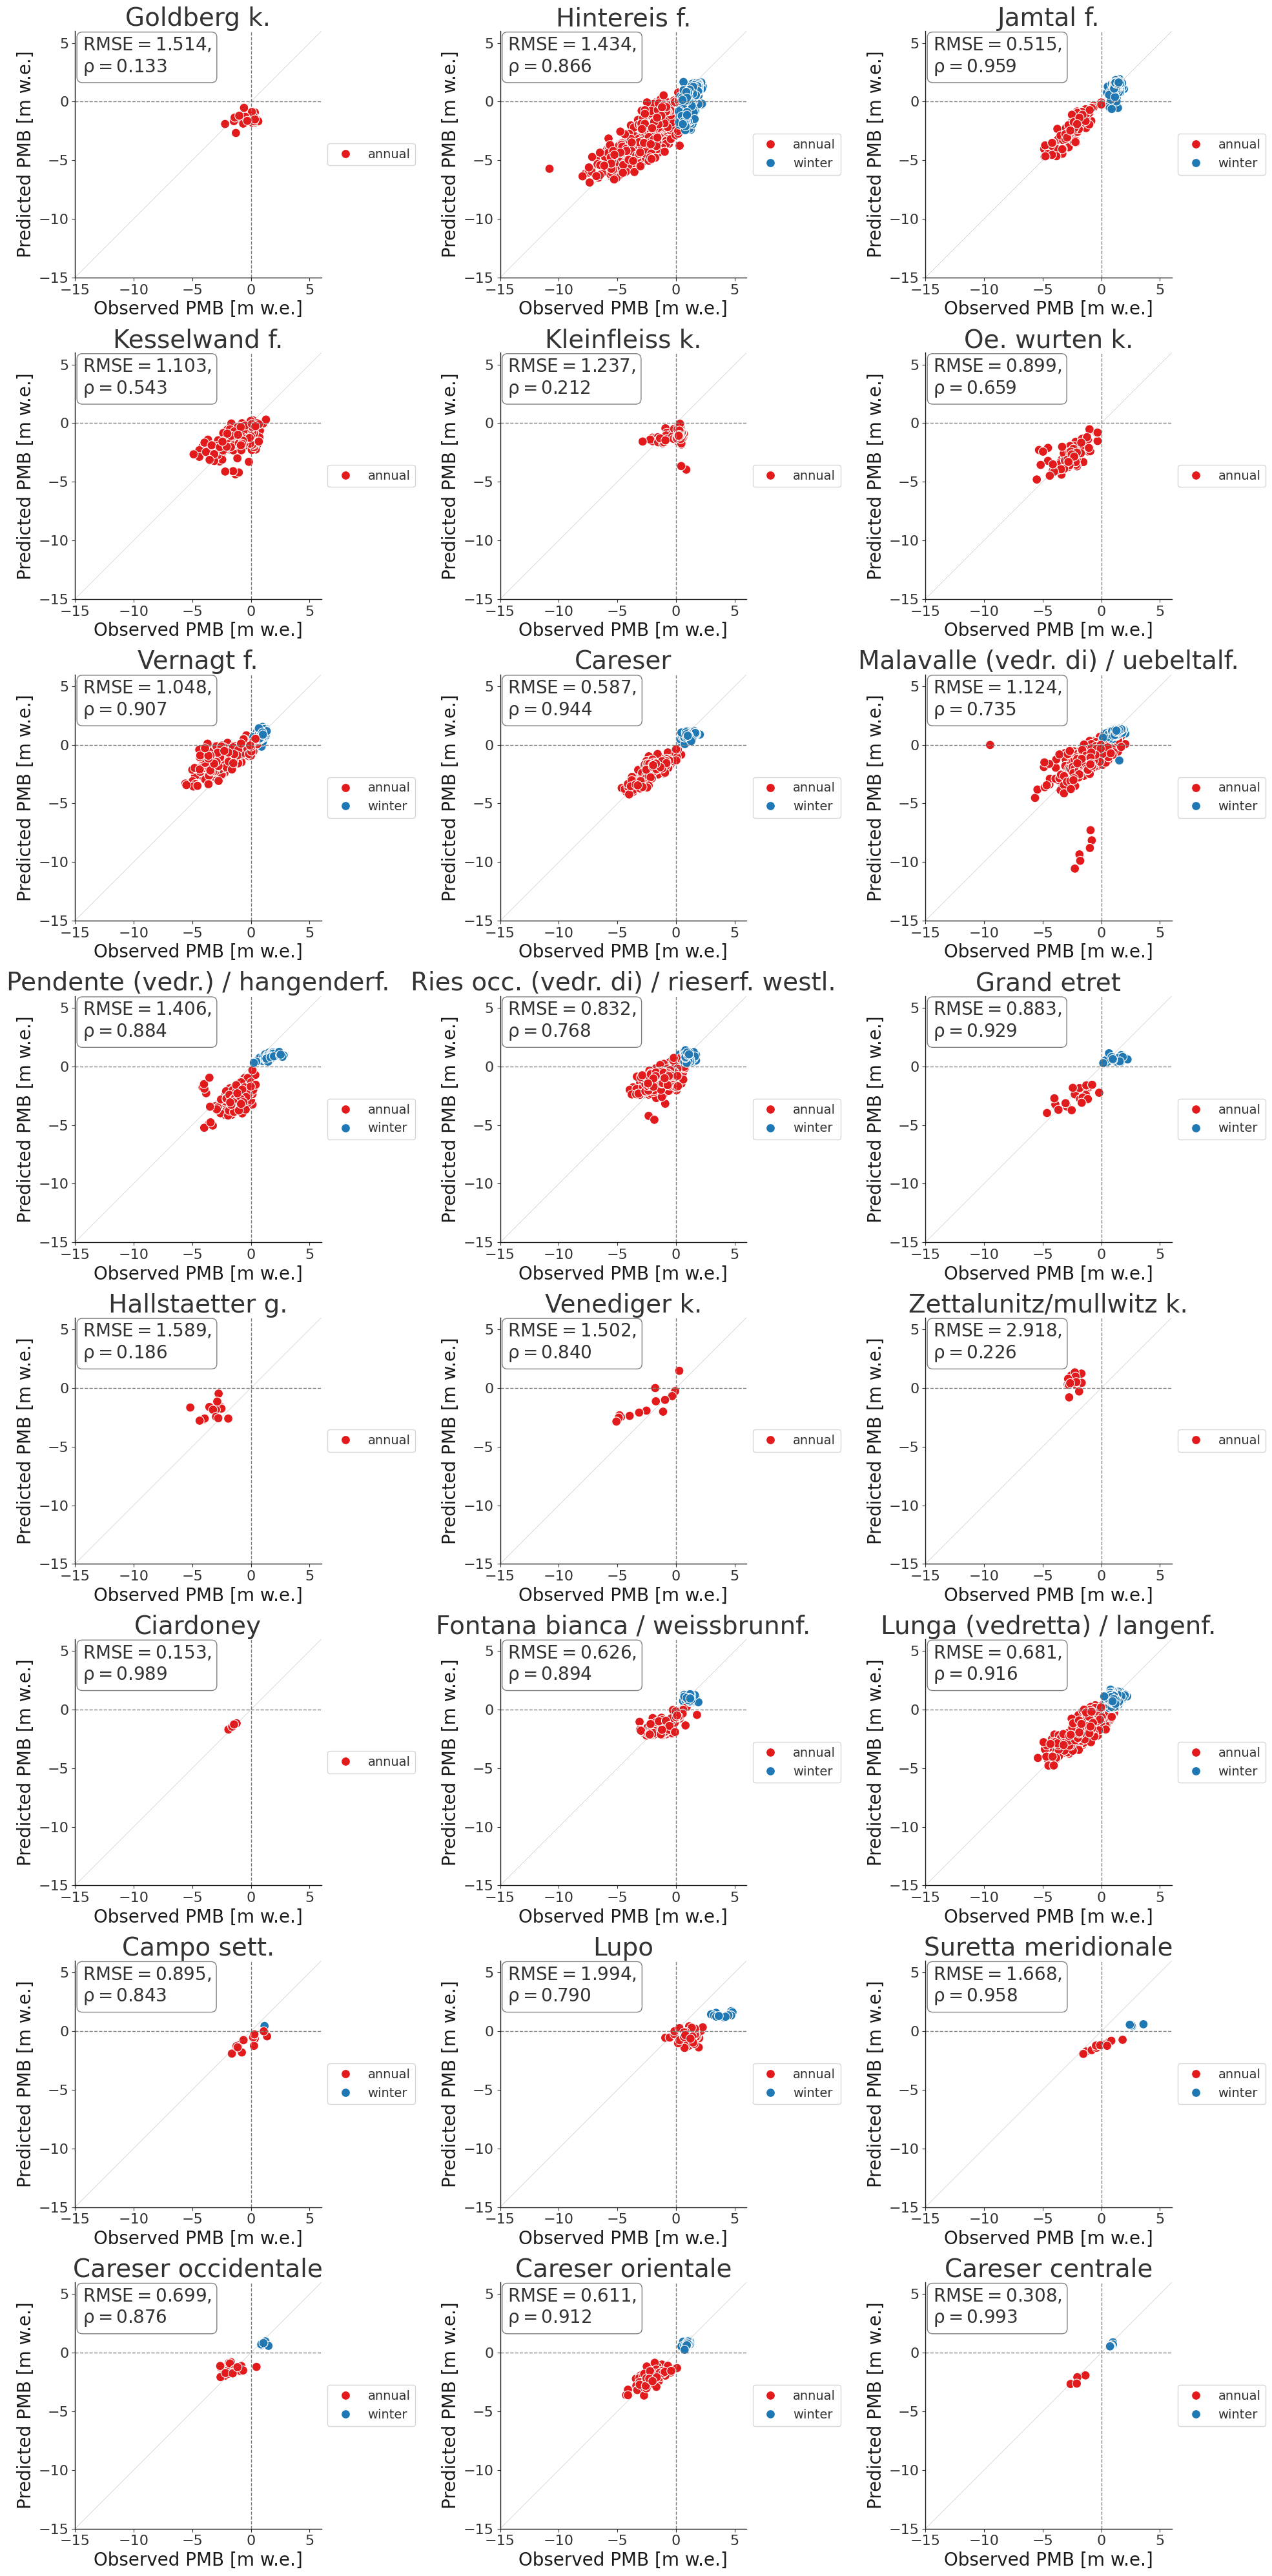

In [21]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

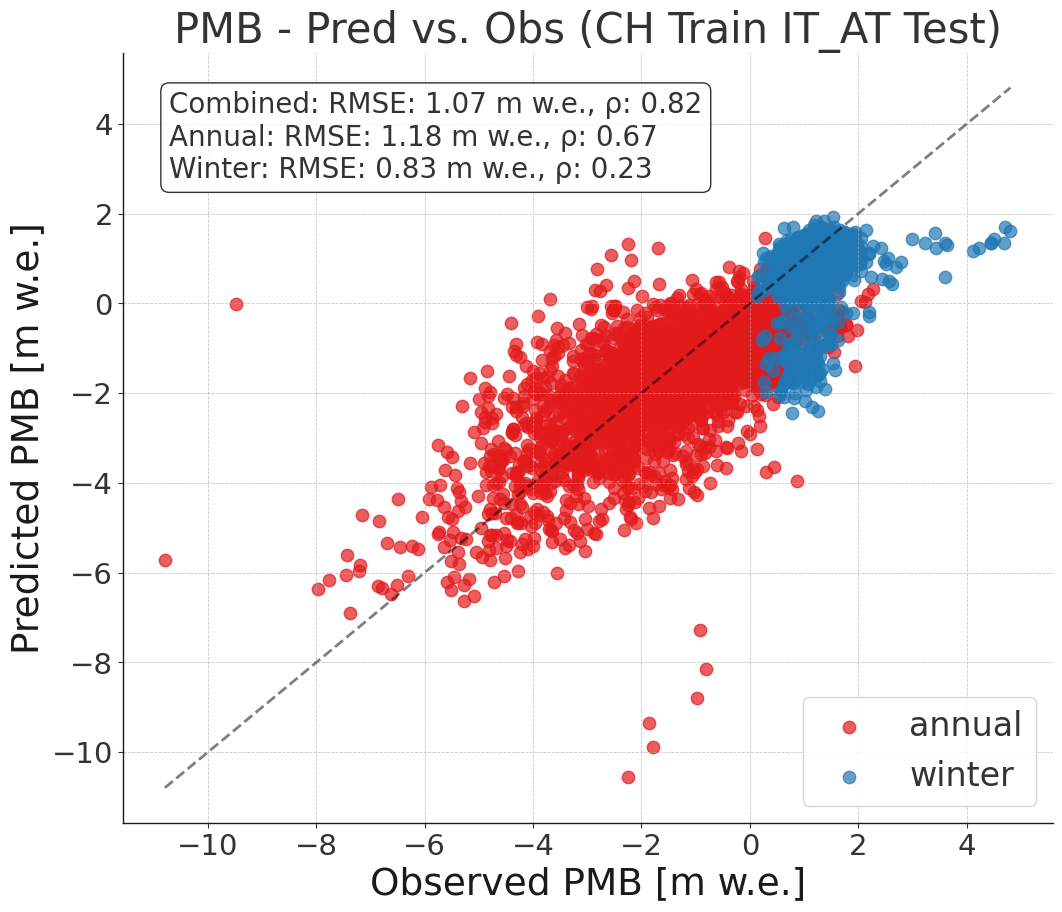

In [22]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='CH Train IT_AT Test', include_summer = False)

In [ ]:
# Search for points with large prediction errors
grouped_ids_test = grouped_ids.copy()
grouped_ids_test['pmb_diff'] = grouped_ids_test['target'] - grouped_ids_test['pred']
pd.set_option('display.max_colwidth', None) 
display(grouped_ids_test[abs(grouped_ids_test['pmb_diff'] > 8)
])
pd.reset_option('display.max_colwidth')

# Plot climate variables for specific points
point_ids = [ 'MALAVALLE (VEDR. DI) / UEBELTALF._2017_18059_IT',
            'MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT'
]
plot_point_climate_variables(
    point_ids=point_ids,
    data_monthly=data_monthly_CH_IT_AT,
    vois_climate=vois_climate,
    vois_units=vois_units
)

### Predictions of custom parameters:

In [ ]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'MBM tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

FIPlot(custom_model, feature_columns, vois_climate)